# 0.Import modules

In [22]:
import sys
import os
from pathlib import Path

import gc
import warnings

from datetime import datetime
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as se
import scipy.stats as stats
from tqdm import tqdm

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [23]:

# Set view options
se.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

%matplotlib inline

#   1.Business Understanding

In Kaggle's GoDaddy Microbusiness Density Forecasting competition, we are given 3135 time series of length 39. These time series are 39 month observations from 3135 unique USA counties between the months of August 2019 thru October 2022 inclusive. We are asked to predict microbusiness density for the next 8 months which are November 2022 thru June 2023 inclusive. Microbusiness density is the number of microbusinesses per 100 adults in specific county. We are asked to make 25080 predictions = 3135 * 8 and the public LB is the evaluation of 3135 predictions for the most recent month using SMAPE metric. The private LB is the evaluation of predictions after current month.


# 2.Load data

1. train.csv - the training set

    1.1 row_id - An ID code for the row.

    1.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    1.3 county_name - The written name of the county.

    1.4 state_name - The name of the state.

    1.5 first_day_of_month - The date of the first day of the month.

    1.6 microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
    
    1.7 active - The raw count of microbusinesses in the county. Not provided for the test set.

2. revealed_test.csv - the new part of train set. The same scheme as train.csv

3. census_starter.csv Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

    3.1 pct_bb_[year] - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.

    3.2 cfips - The CFIPS code.

    3.3 pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.

    3.4 pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.

    3.5 pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
    3.6 median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

4. test.csv Metadata for the submission rows. This file will remain unchanged throughout the competition.

    4.1 row_id - An ID code for the row.

    4.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    4.3 first_day_of_month - The date of the first day of the month.

5. sample_submission.csv A valid sample submission. This file will remain unchanged throughout the competition.

    5.1 row_id - An ID code for the row.
    
    5.2 microbusiness_density - The target variable.

In [24]:
#Paths
DATA_PATH = Path("../data")
DATA_PROCESSED_PATH = DATA_PATH / "processed"

In [25]:
train = pd.read_csv(DATA_PATH / "raw/train.csv")
train_revealed = pd.read_csv(DATA_PATH / "raw/revealed_test.csv")

submission_template = pd.read_csv(DATA_PATH / "raw/test.csv")
census = pd.read_csv(DATA_PATH / "raw/census_starter.csv")
submission_example = pd.read_csv(DATA_PATH / "raw/sample_submission.csv")

train = pd.concat([train, train_revealed])

train['ds'] = pd.to_datetime(train['first_day_of_month'])
train['year'] = train['ds'].dt.year
train['month'] = train['ds'].dt.month

In [26]:
submission_baseline = pd.read_csv('../notebooks/submission.csv')
submission_baseline.head()

row_id  microbusiness_density
0  1001_2022-11-01               3.332508
1  1001_2022-12-01               3.332508
2  1001_2023-01-01               3.332508
3  1001_2023-02-01               3.332508
4  1001_2023-03-01               3.332508

# 3 Model

In [27]:
# A bunch of useful functions
def from_active_to_density(submission):
    COLS = ["GEO_ID", "NAME", "S0101_C01_026E"]
    df2020 = pd.read_csv(
        DATA_PATH / "external/census/ACSST5Y2020.S0101-Data.csv", usecols=COLS
    )
    df2020 = df2020.iloc[1:]
    df2020["S0101_C01_026E"] = df2020["S0101_C01_026E"].astype("int")

    df2021 = pd.read_csv(
        DATA_PATH / "external/census/ACSST5Y2021.S0101-Data.csv", usecols=COLS
    )
    df2021 = df2021.iloc[1:]
    df2021["S0101_C01_026E"] = df2021["S0101_C01_026E"].astype("int")
    df2021.head()

    df2020["cfips"] = df2020.GEO_ID.apply(lambda x: int(x.split("US")[-1]))
    adult2020 = df2020.set_index("cfips").S0101_C01_026E.to_dict()

    df2021["cfips"] = df2021.GEO_ID.apply(lambda x: int(x.split("US")[-1]))
    adult2021 = df2021.set_index("cfips").S0101_C01_026E.to_dict()

    submission["adult2020"] = submission.cfips.map(adult2020)
    submission["adult2021"] = submission.cfips.map(adult2021)

    submission["microbusiness_density"] = (
        submission["microbusiness_density"].round() * 100 / submission["adult2021"]
    )

In [28]:
train.head()

row_id  cfips          county    state first_day_of_month  \
0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active         ds  year  month  
0               3.007682    1249 2019-08-01  2019      8  
1               2.884870    1198 2019-09-01  2019      9  
2               3.055843    1269 2019-10-01  2019     10  
3               2.993233    1243 2019-11-01  2019     11  
4               2.993233    1243 2019-12-01  2019     12

In [29]:
cfips_list = train['cfips'].unique()

In [30]:
#drop rows with 2022-12-01
train = train[train['ds'] != '2022-12-01']

In [31]:
prediction_df = pd.DataFrame()

for cfip in tqdm(cfips_list):
    train_data = TimeSeriesDataFrame.from_data_frame(
    train[train.cfips == cfip],
    id_column="cfips",
    timestamp_column="ds",
    )

    predictor = TimeSeriesPredictor(
    prediction_length=6,
    path="autogluon_v3_best_quality",
    target="active",
    eval_metric="sMAPE",
    )

    predictor.fit(
        train_data,
        presets="medium_quality",
        time_limit=600,
        verbosity=0,
    )

    predictions = predictor.predict(train_data)
    prediction_df = pd.concat([prediction_df, predictions])

  0%|          | 0/3135 [00:00<?, ?it/s]Warning: path already exists! This predictor may overwrite an existing predictor! path="autogluon_v3_best_quality"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 6,
 'random_seed': None,
 'target': 'active',
 'time_limit': 600,
 'verbosity': 0}
Provided training data set with 40 rows, 1 items (item = single time series). Average time series length is 40.0.
Training artifacts will be saved to: /Users/Artem_Boltaev/Documents/EPAM Projects/4. Microbisuness_Density_Forecasting_Kaggle/source_code/microbisuness_density_forecasting_kaggle/notebooks/autogluon_v3_best_quality
No path specified. Models will be saved in: "AutogluonModels/ag-20230309_194450/"
ETS with seasonal = add requires seasonal_period > 

In [32]:
prediction_df.head(10)

mean           0.1           0.2           0.3  \
item_id timestamp                                                            
1001    2022-12-01   1476.365697   1444.576429   1455.489032   1463.357786   
        2023-01-01   1474.393712   1429.991841   1445.234092   1456.224826   
        2023-02-01   1487.740298   1433.132409   1451.878176   1465.395193   
        2023-03-01   1485.787400   1422.993678   1444.549473   1460.092718   
        2023-04-01   1499.114923   1428.733924   1452.894276   1470.315589   
        2023-05-01   1497.181064   1420.274783   1446.675130   1465.711637   
1003    2022-12-01  14219.395019  13896.402366  14007.279110  14087.229044   
        2023-01-01  14289.505330  13836.716586  13992.149662  14104.227846   
        2023-02-01  14359.575644  13806.694599  13996.487307  14133.341202   
        2023-03-01  14429.645584  13792.199949  14011.021944  14168.807997   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
1001    2022-12-01   1470.081347   1476.365697   1482.650048   1489.373608   
        2023-01-01   1465.616004   1474.393712   1483.171420   1492.562597   
        2023-02-01   1476.944985   1487.740298   1498.535612   1510.085404   
        2023-03-01   1473.373847   1485.787400   1498.200952   1511.482082   
        2023-04-01   1485.201459   1499.114923   1513.028388   1527.914257   
        2023-05-01   1481.977631   1497.181064   1512.384497   1528.650491   
1003    2022-12-01  14155.543314  14219.395019  14283.246725  14351.560995   
        2023-01-01  14199.994521  14289.505330  14379.016138  14474.782813   
        2023-02-01  14250.277809  14359.575644  14468.873478  14585.810086   
        2023-03-01  14303.630362  14429.645584  14555.660807  14690.483172   

                             0.8           0.9  
item_id timestamp                               
1001    2022-12-01   1497.242363   1508.154966  
        2023-01-01   1503.553332   1518.795582  
        2023-02-01   1523.602421   1542.348188  
        2023-03-01   1527.025326   1548.581121  
        2023-04-01   1545.335571   1569.495922  
        2023-05-01   1547.686998   1574.087345  
1003    2022-12-01  14431.510928  14542.387673  
        2023-01-01  14586.860997  14742.294073  
        2023-02-01  14722.663981  14912.456688  
        2023-03-01  14848.269225  15067.091220

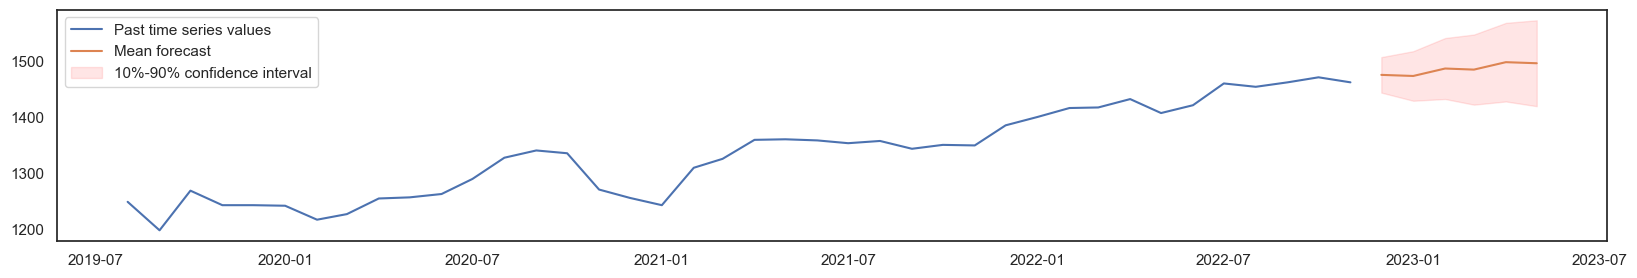

In [33]:
# Plot the predictions


plt.figure(figsize=(20, 3))

item_id = 1001
y_past = train[train.cfips == item_id]["active"].reset_index(drop=True)
x_past = train[train.cfips == item_id][["ds"]].reset_index(drop=True)

x_pred = prediction_df.loc[item_id].reset_index()[["timestamp"]]
y_pred = prediction_df.loc[item_id].reset_index()[["mean"]]

plt.plot(x_past, y_past, label="Past time series values")
plt.plot(x_pred, y_pred, label="Mean forecast")

plt.fill_between(
    prediction_df.loc[item_id].index,
    prediction_df.loc[item_id]["0.1"],
    prediction_df.loc[item_id]["0.9"],
    color="red",
    alpha=0.1,
    label=f"10%-90% confidence interval",
)
plt.legend()

# 4.Construct inference

inference from 2022-11-01 to 2023-05-01 <br>
2023-06-01 - not evaluate but need to predict

In [34]:
submission = submission_template.copy()
predictions = prediction_df.copy()

In [35]:
submission['first_day_of_month'] = pd.to_datetime(submission['first_day_of_month'])

In [36]:
predictions.reset_index(inplace=True)
predictions.rename(
    columns={"item_id": "cfips", "timestamp": "first_day_of_month"}, inplace=True
)
predictions.head()

cfips first_day_of_month         mean          0.1          0.2  \
0   1001         2022-12-01  1476.365697  1444.576429  1455.489032   
1   1001         2023-01-01  1474.393712  1429.991841  1445.234092   
2   1001         2023-02-01  1487.740298  1433.132409  1451.878176   
3   1001         2023-03-01  1485.787400  1422.993678  1444.549473   
4   1001         2023-04-01  1499.114923  1428.733924  1452.894276   

           0.3          0.4          0.5          0.6          0.7  \
0  1463.357786  1470.081347  1476.365697  1482.650048  1489.373608   
1  1456.224826  1465.616004  1474.393712  1483.171420  1492.562597   
2  1465.395193  1476.944985  1487.740298  1498.535612  1510.085404   
3  1460.092718  1473.373847  1485.787400  1498.200952  1511.482082   
4  1470.315589  1485.201459  1499.114923  1513.028388  1527.914257   

           0.8          0.9  
0  1497.242363  1508.154966  
1  1503.553332  1518.795582  
2  1523.602421  1542.348188  
3  1527.025326  1548.581121  
4  1545.335571  1569.495922

In [37]:
predictions['first_day_of_month'].max()

Timestamp('2023-05-01 00:00:00')

In [38]:
predictions['first_day_of_month'].min()

Timestamp('2022-12-01 00:00:00')

In [39]:
submission = submission.merge(
    predictions[["cfips", "first_day_of_month", "mean"]],
    on=["cfips", "first_day_of_month"],
    how="left",
)
submission.head()

row_id  cfips first_day_of_month  mean
0  1001_2022-11-01   1001         2022-11-01   NaN
1  1003_2022-11-01   1003         2022-11-01   NaN
2  1005_2022-11-01   1005         2022-11-01   NaN
3  1007_2022-11-01   1007         2022-11-01   NaN
4  1009_2022-11-01   1009         2022-11-01   NaN

In [40]:
submission.rename(columns={'mean': 'microbusiness_density'}, inplace=True)
from_active_to_density(submission)
submission.head()

row_id  cfips first_day_of_month  microbusiness_density  \
0  1001_2022-11-01   1001         2022-11-01                    NaN   
1  1003_2022-11-01   1003         2022-11-01                    NaN   
2  1005_2022-11-01   1005         2022-11-01                    NaN   
3  1007_2022-11-01   1007         2022-11-01                    NaN   
4  1009_2022-11-01   1009         2022-11-01                    NaN   

   adult2020  adult2021  
0      42496      44438  
1     171296     178105  
2      19804      19995  
3      17790      17800  
4      44383      45201

In [41]:
submission.dropna().head()

row_id  cfips first_day_of_month  microbusiness_density  \
3135  1001_2022-12-01   1001         2022-12-01               3.321482   
3136  1003_2022-12-01   1003         2022-12-01               7.983493   
3137  1005_2022-12-01   1005         2022-12-01               1.220305   
3138  1007_2022-12-01   1007         2022-12-01               1.275281   
3139  1009_2022-12-01   1009         2022-12-01               1.814119   

      adult2020  adult2021  
3135      42496      44438  
3136     171296     178105  
3137      19804      19995  
3138      17790      17800  
3139      44383      45201

In [42]:
submission.fillna(value=submission_baseline, inplace=True)
submission.head()

row_id  cfips first_day_of_month  microbusiness_density  \
0  1001_2022-11-01   1001         2022-11-01               3.332508   
1  1003_2022-11-01   1003         2022-11-01               3.332508   
2  1005_2022-11-01   1005         2022-11-01               3.332508   
3  1007_2022-11-01   1007         2022-11-01               3.332508   
4  1009_2022-11-01   1009         2022-11-01               3.332508   

   adult2020  adult2021  
0      42496      44438  
1     171296     178105  
2      19804      19995  
3      17790      17800  
4      44383      45201

In [43]:
submission[["row_id", "microbusiness_density"]].to_csv(
    DATA_PATH / "processed/submission_autogluon_v3_round.csv", index=False
)